In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os
os.chdir("/content/gdrive/My Drive/CS498DL/CS498DL-project/cases")

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define neural network

In [ ]:
# Model
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self, nof=50, dim=2, num_layers=4):
        super().__init__()
        self.dim = dim
        self.input_layer = nn.Linear(dim, nof)
        def f():
          return nn.Sequential(nn.Linear(nof, nof), nn.Tanh())
        self.hidden_layer = nn.Sequential(
            *[f() for _ in range(num_layers)],
        )
        self.output_layer = nn.Linear(nof, 1)


    def forward(self, x, y):
        input = torch.cat((x, y), dim=-1)
        input = torch.tanh(self.input_layer(input))
        input = self.hidden_layer(input)
        input = self.output_layer(input)
        return input

# Initialize data and forcing function

In [ ]:
def load_data(character, stride_i=1, stride_b=1, dir='domain_data'):
    dir = dir + '/'
    infile = dir + 'shape_data_' + character + '.npz'
    record = np.load(infile)
    boundary_st_idx = np.arange(0, record['boundary'].shape[0], stride_b)
    interior_st_idx = np.arange(0, record['interior'].shape[0], stride_i)
    return record['boundary'][boundary_st_idx], record['interior'][interior_st_idx]

In [ ]:
# Load data
text = 'CS498DL'
# text = 'C'
boundary_data = {}
interior_data = {}
X = {}
Y = {}
Xc = {}
Yc = {}
bound_r_max = {}
for i, c in enumerate(text):
  boundary_data[c], interior_data[c] = load_data(c, stride_i=8)
  boundary_data[c] = torch.Tensor(boundary_data[c])
  interior_data[c] = torch.Tensor(interior_data[c])
  x = torch.hstack((boundary_data[c][:,0], interior_data[c][:,0]))
  y = torch.hstack((boundary_data[c][:,1], interior_data[c][:,1]))
  X[c] = x.unsqueeze(-1).to(device)
  Y[c] = y.unsqueeze(-1).to(device)
  Xc[c] = X[c].clone().to(device)
  Xc[c].requires_grad = True
  Yc[c] = Y[c].clone().to(device)
  Yc[c].requires_grad = True
  theta = torch.atan2(boundary_data[c][:,1], boundary_data[c][:,0])
  bound_r_max[c] = torch.sin((i+1) * theta).to(device)

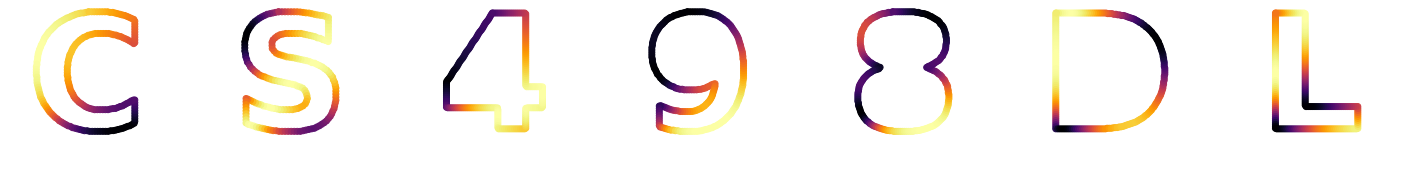

In [ ]:
def plot(*args):
  return map(lambda x : x.cpu().detach().numpy(), args)

# c = 'C'
n_char = len(text)
fig, axs = plt.subplots(1, n_char, figsize=(25,4))

for i, c in enumerate(text):  
  scat = axs[i].scatter(*plot(boundary_data[c][:,0], boundary_data[c][:,1]), c=[*plot(bound_r_max[c])], cmap="inferno")
  axs[i].set_xlim([0,1])
  axs[i].set_ylim([0,1])
  axs[i].set_aspect('equal')
  divider = make_axes_locatable(axs[i])
  cax = divider.append_axes("right", size="5%", pad=0.05)
  cax.axis('off')
  axs[i].axis('off')


# Loss functions for different pdes

In [ ]:
# loss functions
def pde_loss_poisson(pred, x, y, lambda_pde):
    gridsize = x.size(0)
    du_dx = torch.autograd.grad(pred.sum(), x, create_graph=True)[0]
    du2_dx2 = torch.autograd.grad(du_dx.sum(), x, create_graph=True)[0]
    du_dy = torch.autograd.grad(pred.sum(), y, create_graph=True)[0]
    du2_dy2 = torch.autograd.grad(du_dy.sum(), y, create_graph=True)[0]
    loss = torch.sum(torch.square(du2_dx2 + du2_dy2))
    return lambda_pde * loss / (gridsize)

def boundary_loss_dirichlet(pred, bound_r_max, lambda_bound=1.0):
    bound_size = bound_r_max.size(0)
    loss = torch.sum((pred[:bound_size, 0] - bound_r_max) ** 2)
    return lambda_bound * loss / bound_size


# Define analytical solutions for comparison

In [ ]:
# define network
nets = {}
optimizers = {}
for c in text:
  nets[c] = Net(nof=50, num_layers=3).to(device)

  # define optimizer
  learning_rate = 0.003
  optimizers[c] = torch.optim.Adam(nets[c].parameters(), lr=learning_rate)

Epoch 0 for 'C' --- Loss : 3.66221022605896, pde_loss : 0.0003326126025058329, bound_loss : 3.6618776321411133
Epoch 2500 for 'C' --- Loss : 0.002440983196720481, pde_loss : 5.614754991256632e-05, bound_loss : 0.002384835621342063
Epoch 5000 for 'C' --- Loss : 0.0022119174245744944, pde_loss : 5.784357199445367e-05, bound_loss : 0.0021540739107877016
Epoch 7500 for 'C' --- Loss : 0.0032888446003198624, pde_loss : 0.0010912826983258128, bound_loss : 0.0021975617855787277
Epoch 10000 for 'C' --- Loss : 0.0019435483263805509, pde_loss : 7.876505696913227e-05, bound_loss : 0.0018647832330316305
Epoch 12500 for 'C' --- Loss : 0.0035134737845510244, pde_loss : 0.0014364689122885466, bound_loss : 0.002077004872262478
Epoch 15000 for 'C' --- Loss : 0.0019642701372504234, pde_loss : 0.00015268825518433005, bound_loss : 0.0018115817802026868
Epoch 17500 for 'C' --- Loss : 0.00256617390550673, pde_loss : 0.000691951485350728, bound_loss : 0.001874222420156002
Epoch 20000 for 'C' --- Loss : 0.0020

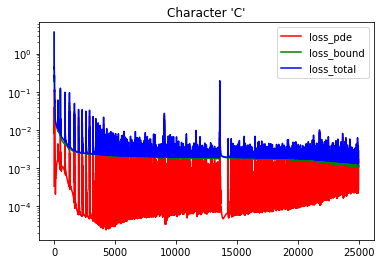

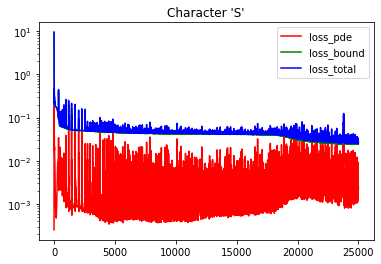

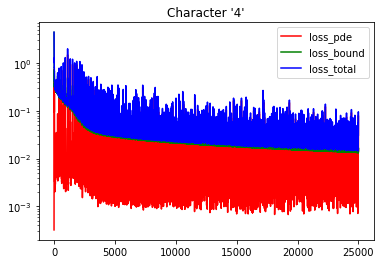

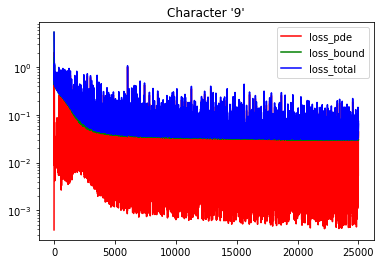

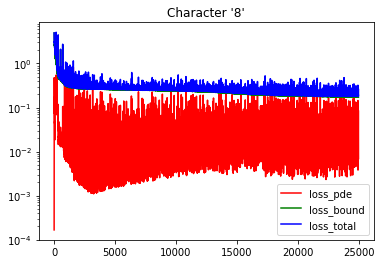

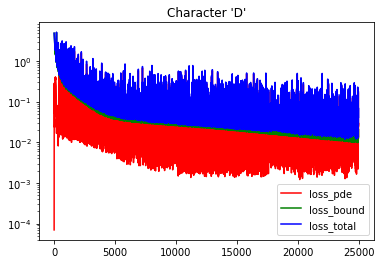

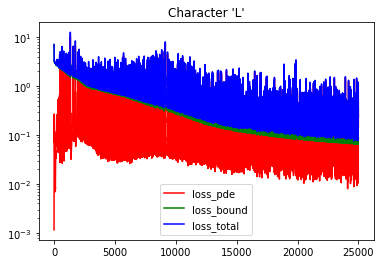

In [ ]:
# train
for c in text:
# for c in 'C':
  num_epochs = 25000
  lambda_pde = 1.0
  lambda_bound = 10.0
  log = {"loss_pde" : [],
        "loss_bound" : [],
        "loss_total" : []}
  for epoch in range(num_epochs):
      if epoch % 2000 == 0:
          learning_rate *= 0.95

      for param_group in optimizer.param_groups:
          param_group['lr'] = learning_rate

      nets[c].train()

      upred = nets[c].forward(Xc[c], Yc[c])

      loss_bound = boundary_loss_dirichlet(upred, bound_r_max[c], lambda_bound=lambda_bound)
      loss_pde = pde_loss_poisson(upred, Xc[c], Yc[c], lambda_pde)
      loss = loss_pde + loss_bound
      log["loss_pde"].append(loss_pde.item())
      log["loss_bound"].append(loss_bound.item())
      log["loss_total"].append(loss.item())

      optimizers[c].zero_grad()
      loss.backward()
      optimizers[c].step()

      if epoch % 2500 == 0:
          print(f"Epoch {epoch} for '{c}' --- Loss : {loss}, pde_loss : {loss_pde}, bound_loss : {loss_bound}")

  print(f"Final loss : {loss.item()}")
  plt.figure()
  plt.semilogy(log["loss_pde"], 'r', label = 'loss_pde')
  plt.semilogy(log["loss_bound"], 'g', label = 'loss_bound')
  plt.semilogy(log["loss_total"], 'b', label = 'loss_total')
  plt.legend()
  plt.title(f"Character '{c}'")

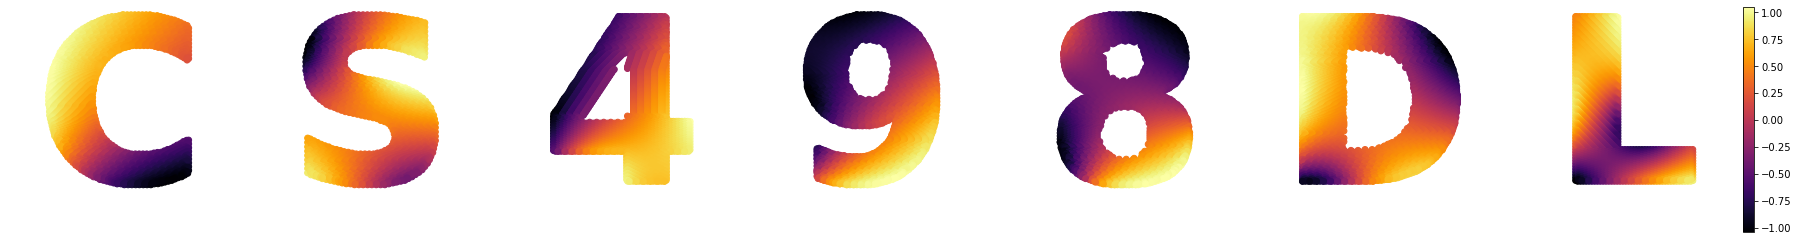

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

n_char = len(text)
fig, axs = plt.subplots(1, n_char, figsize=(25,4))

for i, c in enumerate(text):
  pinn_sol = nets[c].forward(Xc[c], Yc[c])
  scat = axs[i].scatter(*plot(X[c][:,0], Y[c][:,0]), c=[*plot(pinn_sol)], cmap="inferno")
  axs[i].set_xlim([0,1])
  axs[i].set_ylim([0,1])
  axs[i].set_aspect('equal')
  divider = make_axes_locatable(axs[i])
  cax = divider.append_axes("right", size="5%", pad=0.05)
  cax.axis('off')
  axs[i].axis('off')

# divider = make_axes_locatable(axs[-1])
# cax = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(scat, cax=cax)
fig.tight_layout()

In [ ]:
fig.savefig('CS498DL.png', dpi=300)